In [1]:
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
from visualize import *
from calibration import *
from active_learning import *
from collections import defaultdict
from tqdm import tqdm
from spline import *
import collections


NUM_BINS = 10
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 5
NUM_RUN = 50
# limit to the cases when the number of samples is less than 1000
NUM_SAMPLES = [20, 30, 40, 50, 60, 70, 80, 90, 100] + [50 * _ for _ in range(3, 19)] 
print len(NUM_SAMPLES) # should not exceed 25 because the number of subplots is set to be 25.
METHOD_NAME = "binary_spline"

25
25


try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
# DATASET = "cifar100/cifar100_predictions_dropout"
DATASET = "cifar100_predictions_dropout"
data = np.genfromtxt("data/cifar100/%s.txt" % DATASET)# 10000*101
N = data.shape[0]
score = data[:,1:]
Y_predict = np.argmax(score, axis=1)
Y_true = data[:,0]
print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)


# DATASET = "svhn_predictions"
# data = np.genfromtxt("data/svhn/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]


# DATASET = "cifar100_adversarial_predictions"
# data = np.genfromtxt("data/cifar100_adversarial/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]
# print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)

ACC=0.7414


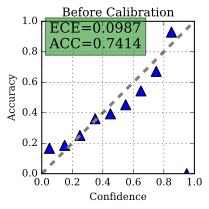

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ece, acc, ax = reliability_plot(ax, score, Y_true, NUM_BINS)
ax.set_title("Before Calibration")
fig.tight_layout()

In [4]:
# train a Spline regression model using all available data points as a reference model.
# MSE between this spline curve and the one trained on selected datapoints will be computed as a metric for evaluation.
gam_ref = LogisticGAM(s(0, constraints='monotonic_inc')).gridsearch(
                    np.max(score, axis=1).reshape(-1, 1),
                    np.array(Y_true == Y_predict) * 1) # add a linear term

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.772
Link Function:                        LogitLink Log Likelihood:                                 -4010.4136
Number of Samples:                        10000 AIC:                                             8028.3711
                                                AICc:                                            8028.3766
                                                UBRE:                                               2.8031
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2984
Feature Function                  Lam

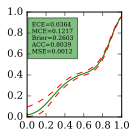

In [5]:
# feed all data into spline regression
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(2)
ece, mce, brier, acc, mse, ax, confi = spline_classification_plot(ax,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           gam_ref)
fig.tight_layout()

# active learning

In [6]:
training_list = [i for i in range(N)]
subset_init = np.random.choice(training_list, size = NUM_SAMPLES[0], replace = False).tolist()

### randomly select datapoints and feed to spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9239
Link Function:                        LogitLink Log Likelihood:                                    -9.6912
Number of Samples:                           20 AIC:                                               23.2301
                                                AICc:                                              24.6574
                                                UBRE:                                               3.2385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1383
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9145
Link Function:                        LogitLink Log Likelihood:                                   -13.6456
Number of Samples:                           30 AIC:                                               31.1202
                                                AICc:                                               31.995
                                                UBRE:                                               3.0884
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1628
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4115
Link Function:                        LogitLink Log Likelihood:                                   -17.2418
Number of Samples:                           40 AIC:                                               39.3066
                                                AICc:                                              40.1524
                                                UBRE:                                               3.0309
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2335
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0874
Link Function:                        LogitLink Log Likelihood:                                   -20.9619
Number of Samples:                           50 AIC:                                               46.0986
                                                AICc:                                              46.6483
                                                UBRE:                                               2.9554
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2684
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.1194
Link Function:                        LogitLink Log Likelihood:                                   -26.1632
Number of Samples:                           60 AIC:                                               56.5652
                                                AICc:                                              57.0251
                                                UBRE:                                                2.971
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2246
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.1315
Link Function:                        LogitLink Log Likelihood:                                   -29.3818
Number of Samples:                           70 AIC:                                               63.0267
                                                AICc:                                              63.4195
                                                UBRE:                                               2.9247
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2428
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8086
Link Function:                        LogitLink Log Likelihood:                                   -36.4523
Number of Samples:                           80 AIC:                                               78.5217
                                                AICc:                                              79.0088
                                                UBRE:                                               3.0096
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2085
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8276
Link Function:                        LogitLink Log Likelihood:                                   -44.6651
Number of Samples:                           90 AIC:                                               94.9854
                                                AICc:                                              95.4193
                                                UBRE:                                               3.0805
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1995
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8343
Link Function:                        LogitLink Log Likelihood:                                   -49.2755
Number of Samples:                          100 AIC:                                              104.2196
                                                AICc:                                             104.6091
                                                UBRE:                                               3.0649
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2041
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8181
Link Function:                        LogitLink Log Likelihood:                                    -64.208
Number of Samples:                          150 AIC:                                              134.0522
                                                AICc:                                             134.3056
                                                UBRE:                                               2.9087
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2781
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.487
Link Function:                        LogitLink Log Likelihood:                                   -79.4312
Number of Samples:                          200 AIC:                                              165.8364
                                                AICc:                                             166.0895
                                                UBRE:                                               2.8431
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3585
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.0056
Link Function:                        LogitLink Log Likelihood:                                  -100.0487
Number of Samples:                          250 AIC:                                              206.1086
                                                AICc:                                             206.2723
                                                UBRE:                                               2.8341
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3374
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      4.0562
Link Function:                        LogitLink Log Likelihood:                                  -118.4876
Number of Samples:                          300 AIC:                                              245.0876
                                                AICc:                                             245.2959
                                                UBRE:                                               2.8278
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3473
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6269
Link Function:                        LogitLink Log Likelihood:                                  -137.5814
Number of Samples:                          350 AIC:                                              282.4164
                                                AICc:                                             282.5676
                                                UBRE:                                               2.8152
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.34
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6847
Link Function:                        LogitLink Log Likelihood:                                  -161.6365
Number of Samples:                          400 AIC:                                              330.6423
                                                AICc:                                             330.7774
                                                UBRE:                                                2.834
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3185
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7048
Link Function:                        LogitLink Log Likelihood:                                   -184.424
Number of Samples:                          450 AIC:                                              376.2576
                                                AICc:                                             376.3784
                                                UBRE:                                               2.8427
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3013
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8297
Link Function:                        LogitLink Log Likelihood:                                  -209.4994
Number of Samples:                          500 AIC:                                              426.6581
                                                AICc:                                              426.772
                                                UBRE:                                               2.8594
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2864
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6745
Link Function:                        LogitLink Log Likelihood:                                  -229.2046
Number of Samples:                          550 AIC:                                              465.7581
                                                AICc:                                             465.8555
                                                UBRE:                                               2.8522
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2821
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9543
Link Function:                        LogitLink Log Likelihood:                                  -245.4584
Number of Samples:                          600 AIC:                                              496.8254
                                                AICc:                                             496.8913
                                                UBRE:                                                2.832
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2925
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7226
Link Function:                        LogitLink Log Likelihood:                                  -265.2544
Number of Samples:                          650 AIC:                                              537.9539
                                                AICc:                                             538.0378
                                                UBRE:                                               2.8322
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2859
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7285
Link Function:                        LogitLink Log Likelihood:                                  -281.9796
Number of Samples:                          700 AIC:                                              571.4163
                                                AICc:                                             571.4943
                                                UBRE:                                               2.8206
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2856
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6539
Link Function:                        LogitLink Log Likelihood:                                  -307.7158
Number of Samples:                          750 AIC:                                              622.7394
                                                AICc:                                             622.8101
                                                UBRE:                                               2.8342
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2751
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6775
Link Function:                        LogitLink Log Likelihood:                                  -333.1388
Number of Samples:                          800 AIC:                                              673.6325
                                                AICc:                                             673.6993
                                                UBRE:                                               2.8457
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.275
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6855
Link Function:                        LogitLink Log Likelihood:                                  -349.8276
Number of Samples:                          850 AIC:                                              707.0262
                                                AICc:                                             707.0893
                                                UBRE:                                               2.8353
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2818
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6928
Link Function:                        LogitLink Log Likelihood:                                  -374.8602
Number of Samples:                          900 AIC:                                              757.1059
                                                AICc:                                             757.1657
                                                UBRE:                                               2.8445
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2775
Feature Function                  Lam

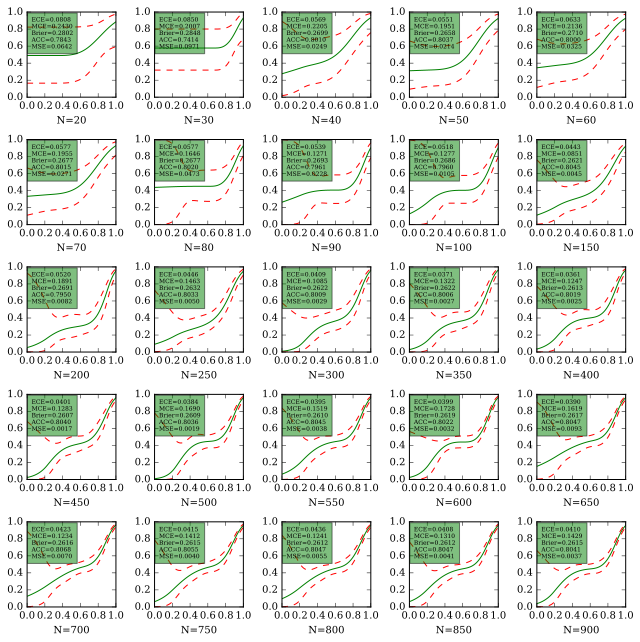

In [7]:
ece_random_emp, mce_random_emp, brier_random_emp, acc_random_emp, mse_random_emp, subset_random_emp = active_learning_plot(
    score, Y_predict, Y_true, acq_random_emp, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9239
Link Function:                        LogitLink Log Likelihood:                                    -9.6912
Number of Samples:                           20 AIC:                                               23.2301
                                                AICc:                                              24.6574
                                                UBRE:                                               3.2385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1383
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9739
Link Function:                        LogitLink Log Likelihood:                                   -15.7353
Number of Samples:                           30 AIC:                                               35.4185
                                                AICc:                                              36.3267
                                                UBRE:                                               3.2333
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.176
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4751
Link Function:                        LogitLink Log Likelihood:                                   -19.7838
Number of Samples:                           40 AIC:                                               44.5179
                                                AICc:                                              45.3934
                                                UBRE:                                               3.1624
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2651
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -25.5796
Number of Samples:                           50 AIC:                                               55.1594
                                                AICc:                                              55.6811
                                                UBRE:                                               3.1352
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2398
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3702
Link Function:                        LogitLink Log Likelihood:                                   -28.7898
Number of Samples:                           60 AIC:                                               62.3201
                                                AICc:                                              62.8496
                                                UBRE:                                               3.0703
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.287
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3954
Link Function:                        LogitLink Log Likelihood:                                   -31.7983
Number of Samples:                           70 AIC:                                               68.3875
                                                AICc:                                              68.8425
                                                UBRE:                                               3.0043
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3304
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.1403
Link Function:                        LogitLink Log Likelihood:                                   -36.3146
Number of Samples:                           80 AIC:                                               76.9098
                                                AICc:                                              77.2525
                                                UBRE:                                               2.9828
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3403
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.7682
Link Function:                        LogitLink Log Likelihood:                                   -43.1408
Number of Samples:                           90 AIC:                                               91.8181
                                                AICc:                                              92.2397
                                                UBRE:                                               3.0448
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3075
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8192
Link Function:                        LogitLink Log Likelihood:                                   -50.0208
Number of Samples:                          100 AIC:                                                105.68
                                                AICc:                                             106.0668
                                                UBRE:                                               3.0794
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2775
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.0076
Link Function:                        LogitLink Log Likelihood:                                   -78.0167
Number of Samples:                          150 AIC:                                              162.0486
                                                AICc:                                             162.3255
                                                UBRE:                                               3.0964
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2462
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.0757
Link Function:                        LogitLink Log Likelihood:                                  -100.6477
Number of Samples:                          200 AIC:                                              207.4467
                                                AICc:                                              207.659
                                                UBRE:                                               3.0495
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.265
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.1977
Link Function:                        LogitLink Log Likelihood:                                   -136.331
Number of Samples:                          250 AIC:                                              279.0575
                                                AICc:                                             279.2358
                                                UBRE:                                               3.1265
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2096
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2419
Link Function:                        LogitLink Log Likelihood:                                  -161.6963
Number of Samples:                          300 AIC:                                              329.8764
                                                AICc:                                             330.0272
                                                UBRE:                                               3.1082
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2182
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.2958
Link Function:                        LogitLink Log Likelihood:                                  -192.0527
Number of Samples:                          350 AIC:                                              390.6971
                                                AICc:                                             390.8291
                                                UBRE:                                               3.1238
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                      0.2
Feature Function                  Lam

 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3448
Link Function:                        LogitLink Log Likelihood:                                  -225.5742
Number of Samples:                          400 AIC:                                              457.8379
                                                AICc:                                             457.9556
                                                UBRE:                                               3.1513
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1805
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7751
Link Function:                        LogitLink Log Likelihood:                                  -257.0338
Number of Samples:                          450 AIC:                                              521.6178
                                                AICc:                                             521.7419
                                                UBRE:                                               3.1659
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1707
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7911
Link Function:                        LogitLink Log Likelihood:                                  -285.0291
Number of Samples:                          500 AIC:                                              577.6405
                                                AICc:                                             577.7528
                                                UBRE:                                               3.1613
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1754
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3672
Link Function:                        LogitLink Log Likelihood:                                  -310.6686
Number of Samples:                          550 AIC:                                              628.0715
                                                AICc:                                             628.1576
                                                UBRE:                                               3.1468
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1831
Feature Function                  Lam

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9376
Link Function:                        LogitLink Log Likelihood:                                  -343.3286
Number of Samples:                          600 AIC:                                              694.5324
                                                AICc:                                             694.6311
                                                UBRE:                                               3.1628
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.173
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9599
Link Function:                        LogitLink Log Likelihood:                                  -373.5042
Number of Samples:                          650 AIC:                                              754.9282
                                                AICc:                                               755.02
                                                UBRE:                                               3.1663
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1695
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9809
Link Function:                        LogitLink Log Likelihood:                                  -400.2649
Number of Samples:                          700 AIC:                                              808.4917
                                                AICc:                                             808.5775
                                                UBRE:                                               3.1595
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1729
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       4.011
Link Function:                        LogitLink Log Likelihood:                                  -434.7133
Number of Samples:                          750 AIC:                                              877.4487
                                                AICc:                                             877.5297
                                                UBRE:                                               3.1742
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1617
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9153
Link Function:                        LogitLink Log Likelihood:                                  -462.4137
Number of Samples:                          800 AIC:                                              932.6581
                                                AICc:                                             932.7314
                                                UBRE:                                               3.1697
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1641
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                         3.8
Link Function:                        LogitLink Log Likelihood:                                  -494.1153
Number of Samples:                          850 AIC:                                              995.8307
                                                AICc:                                             995.8967
                                                UBRE:                                               3.1751
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1601
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8085
Link Function:                        LogitLink Log Likelihood:                                  -524.5368
Number of Samples:                          900 AIC:                                             1056.6907
                                                AICc:                                            1056.7531
                                                UBRE:                                               3.1775
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1583
Feature Function                  Lam

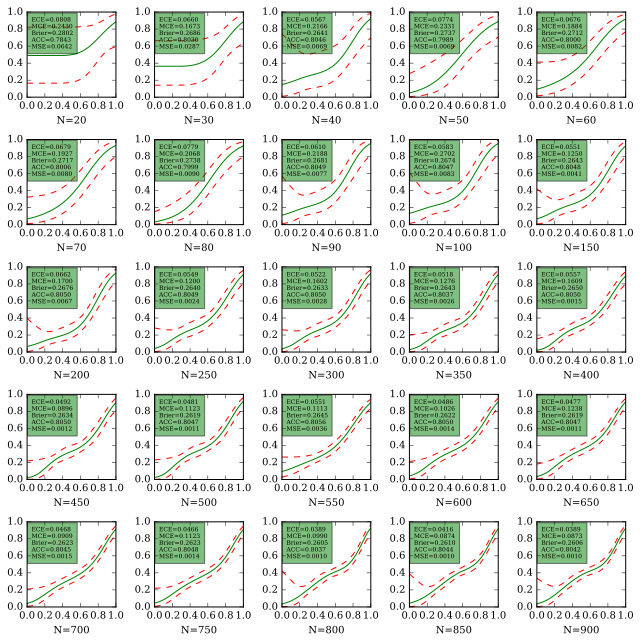

In [8]:
ece_random_unf, mce_random_unf, brier_random_unf, acc_random_unf, mse_random_unf, subset_random_unf = active_learning_plot(
    score, Y_predict, Y_true, acq_random_unf, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9239
Link Function:                        LogitLink Log Likelihood:                                    -9.6912
Number of Samples:                           20 AIC:                                               23.2301
                                                AICc:                                              24.6574
                                                UBRE:                                               3.2385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1383
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6544
Link Function:                        LogitLink Log Likelihood:                                   -15.7855
Number of Samples:                           30 AIC:                                               36.8797
                                                AICc:                                              38.2219
                                                UBRE:                                               3.3001
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1386
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -23.6821
Number of Samples:                           40 AIC:                                               51.3644
                                                AICc:                                              52.0311
                                                UBRE:                                               3.3241
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1051
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -29.7128
Number of Samples:                           50 AIC:                                               63.4259
                                                AICc:                                              63.9477
                                                UBRE:                                               3.3005
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1265
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -35.7108
Number of Samples:                           60 AIC:                                               75.4219
                                                AICc:                                              75.8505
                                                UBRE:                                               3.2837
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1386
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -39.3819
Number of Samples:                           70 AIC:                                               82.7641
                                                AICc:                                              83.1278
                                                UBRE:                                               3.2052
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.184
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -46.1605
Number of Samples:                           80 AIC:                                               96.3213
                                                AICc:                                              96.6371
                                                UBRE:                                                3.224
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1672
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -52.3632
Number of Samples:                           90 AIC:                                              108.7268
                                                AICc:                                             109.0059
                                                UBRE:                                               3.2259
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1606
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0002
Link Function:                        LogitLink Log Likelihood:                                   -58.7714
Number of Samples:                          100 AIC:                                              121.5432
                                                AICc:                                             121.7932
                                                UBRE:                                               3.2314
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1511
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0003
Link Function:                        LogitLink Log Likelihood:                                   -90.1119
Number of Samples:                          150 AIC:                                              184.2244
                                                AICc:                                             184.3889
                                                UBRE:                                               3.2388
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1323
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0004
Link Function:                        LogitLink Log Likelihood:                                  -120.6524
Number of Samples:                          200 AIC:                                              245.3054
                                                AICc:                                             245.4279
                                                UBRE:                                               3.2345
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1287
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0004
Link Function:                        LogitLink Log Likelihood:                                  -148.8473
Number of Samples:                          250 AIC:                                              301.6953
                                                AICc:                                             301.7929
                                                UBRE:                                               3.2132
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1385
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0005
Link Function:                        LogitLink Log Likelihood:                                  -180.8719
Number of Samples:                          300 AIC:                                              365.7446
                                                AICc:                                             365.8257
                                                UBRE:                                               3.2245
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1262
Feature Function                  Lam

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.1241
Link Function:                        LogitLink Log Likelihood:                                   -211.059
Number of Samples:                          350 AIC:                                              426.3662
                                                AICc:                                             426.4407
                                                UBRE:                                                3.223
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1233
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0006
Link Function:                        LogitLink Log Likelihood:                                  -241.3669
Number of Samples:                          400 AIC:                                              486.7349
                                                AICc:                                             486.7956
                                                UBRE:                                               3.2208
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1178
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0007
Link Function:                        LogitLink Log Likelihood:                                  -269.5412
Number of Samples:                          450 AIC:                                              543.0838
                                                AICc:                                             543.1376
                                                UBRE:                                               3.2104
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.123
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4505
Link Function:                        LogitLink Log Likelihood:                                   -302.257
Number of Samples:                          500 AIC:                                              609.4151
                                                AICc:                                              609.477
                                                UBRE:                                               3.2228
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1122
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6988
Link Function:                        LogitLink Log Likelihood:                                  -335.2065
Number of Samples:                          550 AIC:                                              677.8106
                                                AICc:                                              677.909
                                                UBRE:                                               3.2378
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1109
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3079
Link Function:                        LogitLink Log Likelihood:                                  -369.5888
Number of Samples:                          600 AIC:                                              745.7934
                                                AICc:                                             745.8703
                                                UBRE:                                               3.2474
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.103
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3314
Link Function:                        LogitLink Log Likelihood:                                  -399.4708
Number of Samples:                          650 AIC:                                              805.6045
                                                AICc:                                             805.6761
                                                UBRE:                                               3.2435
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.103
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3558
Link Function:                        LogitLink Log Likelihood:                                  -430.1179
Number of Samples:                          700 AIC:                                              866.9474
                                                AICc:                                             867.0146
                                                UBRE:                                               3.2423
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1046
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.3685
Link Function:                        LogitLink Log Likelihood:                                    -458.86
Number of Samples:                          750 AIC:                                              924.4569
                                                AICc:                                             924.5199
                                                UBRE:                                               3.2362
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1096
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4027
Link Function:                        LogitLink Log Likelihood:                                  -493.1908
Number of Samples:                          800 AIC:                                              993.1871
                                                AICc:                                              993.247
                                                UBRE:                                               3.2449
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1035
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9695
Link Function:                        LogitLink Log Likelihood:                                  -521.2457
Number of Samples:                          850 AIC:                                             1050.4304
                                                AICc:                                            1050.5007
                                                UBRE:                                               3.2395
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1067
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4563
Link Function:                        LogitLink Log Likelihood:                                  -556.2126
Number of Samples:                          900 AIC:                                             1119.3378
                                                AICc:                                            1119.3921
                                                UBRE:                                               3.2468
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                      0.1
Feature Function                  Lam

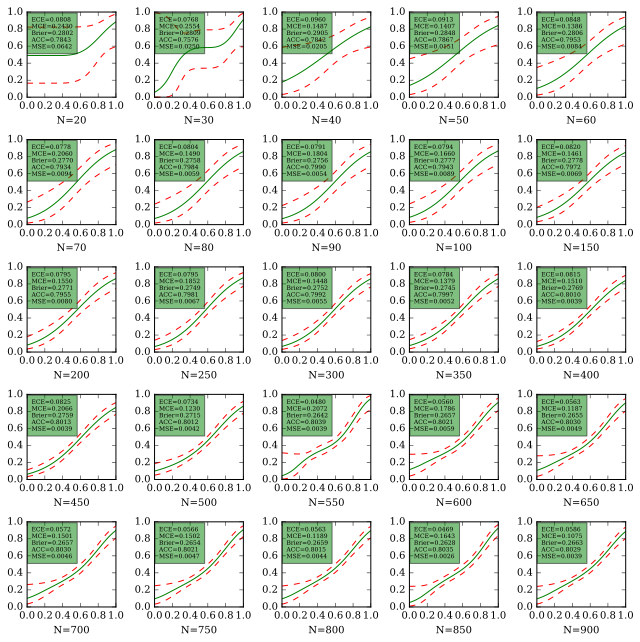

In [9]:
ece_random_ent, mce_random_ent, brier_random_ent, acc_random_ent, mse_random_ent, subset_random_ent = active_learning_plot(
    score, Y_predict, Y_true, acq_random_ent, subset_init, training_list, NUM_SAMPLES, gam_ref)

### actively select datapoints and feed into spline regression

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9239
Link Function:                        LogitLink Log Likelihood:                                    -9.6912
Number of Samples:                           20 AIC:                                               23.2301
                                                AICc:                                              24.6574
                                                UBRE:                                               3.2385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1383
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9422
Link Function:                        LogitLink Log Likelihood:                                    -13.207
Number of Samples:                           30 AIC:                                               30.2983
                                                AICc:                                              31.1885
                                                UBRE:                                               3.0617
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2409
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9656
Link Function:                        LogitLink Log Likelihood:                                    -16.394
Number of Samples:                           40 AIC:                                               36.7193
                                                AICc:                                               37.372
                                                UBRE:                                               2.9573
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.35
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.001
Link Function:                        LogitLink Log Likelihood:                                   -21.7783
Number of Samples:                           50 AIC:                                               47.5586
                                                AICc:                                              48.0807
                                                UBRE:                                               2.9832
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3205
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0328
Link Function:                        LogitLink Log Likelihood:                                   -27.6754
Number of Samples:                           60 AIC:                                               59.4163
                                                AICc:                                              59.8533
                                                UBRE:                                               3.0174
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2981
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.2592
Link Function:                        LogitLink Log Likelihood:                                   -30.8891
Number of Samples:                           70 AIC:                                               66.2967
                                                AICc:                                               66.719
                                                UBRE:                                               2.9729
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3382
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3042
Link Function:                        LogitLink Log Likelihood:                                    -37.903
Number of Samples:                           80 AIC:                                               80.4145
                                                AICc:                                              80.7903
                                                UBRE:                                               3.0282
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3009
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3473
Link Function:                        LogitLink Log Likelihood:                                   -44.9836
Number of Samples:                           90 AIC:                                               94.6618
                                                AICc:                                              95.0016
                                                UBRE:                                               3.0727
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2573
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.2045
Link Function:                        LogitLink Log Likelihood:                                   -50.5161
Number of Samples:                          100 AIC:                                               105.441
                                                AICc:                                             105.7223
                                                UBRE:                                                3.072
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2393
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.4674
Link Function:                        LogitLink Log Likelihood:                                   -75.9161
Number of Samples:                          150 AIC:                                              156.7671
                                                AICc:                                               156.98
                                                UBRE:                                               3.0583
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2299
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.041
Link Function:                        LogitLink Log Likelihood:                                  -102.0126
Number of Samples:                          200 AIC:                                              210.1071
                                                AICc:                                             210.3161
                                                UBRE:                                               3.0627
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.229
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6717
Link Function:                        LogitLink Log Likelihood:                                  -125.3892
Number of Samples:                          250 AIC:                                              256.1219
                                                AICc:                                             256.2618
                                                UBRE:                                                3.033
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2268
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.6335
Link Function:                        LogitLink Log Likelihood:                                  -147.8761
Number of Samples:                          300 AIC:                                              301.0193
                                                AICc:                                             301.1333
                                                UBRE:                                               3.0104
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2337
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5382
Link Function:                        LogitLink Log Likelihood:                                  -172.7153
Number of Samples:                          350 AIC:                                              352.5069
                                                AICc:                                             352.6528
                                                UBRE:                                               3.0152
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2368
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5879
Link Function:                        LogitLink Log Likelihood:                                  -199.7185
Number of Samples:                          400 AIC:                                               406.613
                                                AICc:                                              406.743
                                                UBRE:                                               3.0237
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2231
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.685
Link Function:                        LogitLink Log Likelihood:                                   -219.317
Number of Samples:                          450 AIC:                                               446.004
                                                AICc:                                             446.1239
                                                UBRE:                                               2.9977
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2361
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4481
Link Function:                        LogitLink Log Likelihood:                                  -240.5519
Number of Samples:                          500 AIC:                                                 488.0
                                                AICc:                                              488.098
                                                UBRE:                                               2.9815
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2479
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4599
Link Function:                        LogitLink Log Likelihood:                                  -261.7211
Number of Samples:                          550 AIC:                                              530.3619
                                                AICc:                                             530.4514
                                                UBRE:                                               2.9693
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2591
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4824
Link Function:                        LogitLink Log Likelihood:                                  -290.8241
Number of Samples:                          600 AIC:                                               588.613
                                                AICc:                                             588.6957
                                                UBRE:                                               2.9857
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2489
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4961
Link Function:                        LogitLink Log Likelihood:                                  -316.9305
Number of Samples:                          650 AIC:                                              640.8531
                                                AICc:                                             640.9298
                                                UBRE:                                               2.9902
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2496
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5124
Link Function:                        LogitLink Log Likelihood:                                  -335.1659
Number of Samples:                          700 AIC:                                              677.3568
                                                AICc:                                             677.4284
                                                UBRE:                                               2.9717
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2699
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5373
Link Function:                        LogitLink Log Likelihood:                                  -364.9077
Number of Samples:                          750 AIC:                                                736.89
                                                AICc:                                             736.9575
                                                UBRE:                                               2.9863
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.262
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.5541
Link Function:                        LogitLink Log Likelihood:                                   -392.192
Number of Samples:                          800 AIC:                                              791.4923
                                                AICc:                                              791.556
                                                UBRE:                                               2.9929
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2624
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       3.578
Link Function:                        LogitLink Log Likelihood:                                  -416.2528
Number of Samples:                          850 AIC:                                              839.6616
                                                AICc:                                             839.7221
                                                UBRE:                                               2.9912
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2606
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.7835
Link Function:                        LogitLink Log Likelihood:                                  -441.5802
Number of Samples:                          900 AIC:                                              890.7275
                                                AICc:                                             890.7893
                                                UBRE:                                               2.9931
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2561
Feature Function                  Lam

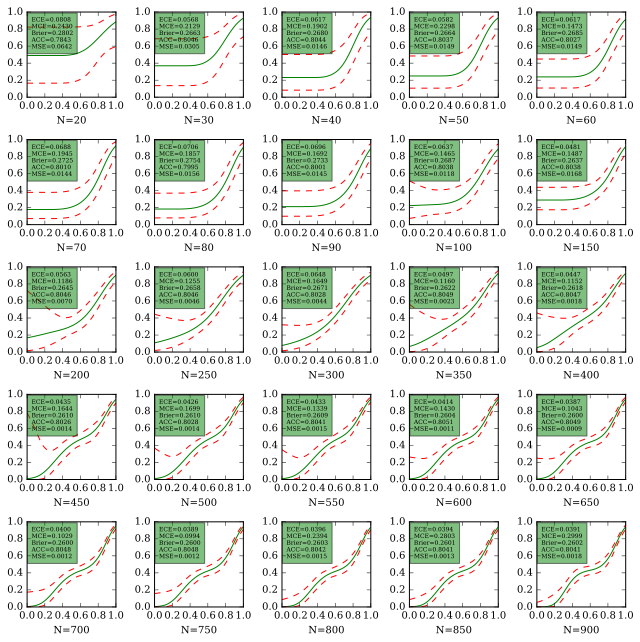

In [10]:
# reweight datapoints acccording to uncertainty
ece_active_prb, mce_active_prb, brier_active_prb, acc_active_prb, mse_active_prb, subset_active_prb = active_learning_plot(
    score, Y_predict, Y_true, acq_active_prb, subset_init, training_list, NUM_SAMPLES, gam_ref)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.9239
Link Function:                        LogitLink Log Likelihood:                                    -9.6912
Number of Samples:                           20 AIC:                                               23.2301
                                                AICc:                                              24.6574
                                                UBRE:                                               3.2385
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1383
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.0001
Link Function:                        LogitLink Log Likelihood:                                   -14.0161
Number of Samples:                           30 AIC:                                               32.0323
                                                AICc:                                              32.9555
                                                UBRE:                                               3.1211
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3238
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8178
Link Function:                        LogitLink Log Likelihood:                                   -19.6935
Number of Samples:                           40 AIC:                                               45.0227
                                                AICc:                                              46.0683
                                                UBRE:                                               3.1819
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2884
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.837
Link Function:                        LogitLink Log Likelihood:                                   -26.6912
Number of Samples:                           50 AIC:                                               59.0563
                                                AICc:                                              59.8782
                                                UBRE:                                               3.2265
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2299
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.8672
Link Function:                        LogitLink Log Likelihood:                                   -31.7704
Number of Samples:                           60 AIC:                                               69.2753
                                                AICc:                                              69.9581
                                                UBRE:                                               3.1928
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2305
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9018
Link Function:                        LogitLink Log Likelihood:                                   -36.8913
Number of Samples:                           70 AIC:                                               79.5863
                                                AICc:                                              80.1739
                                                UBRE:                                               3.1701
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2397
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9101
Link Function:                        LogitLink Log Likelihood:                                   -43.8251
Number of Samples:                           80 AIC:                                               93.4704
                                                AICc:                                              93.9818
                                                UBRE:                                               3.1975
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2097
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9127
Link Function:                        LogitLink Log Likelihood:                                   -48.9339
Number of Samples:                           90 AIC:                                              103.6932
                                                AICc:                                             104.1451
                                                UBRE:                                                3.178
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2111
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9163
Link Function:                        LogitLink Log Likelihood:                                   -55.9426
Number of Samples:                          100 AIC:                                              117.7177
                                                AICc:                                             118.1227
                                                UBRE:                                               3.2005
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1892
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9367
Link Function:                        LogitLink Log Likelihood:                                   -84.4727
Number of Samples:                          150 AIC:                                              174.8189
                                                AICc:                                             175.0868
                                                UBRE:                                               3.1811
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1866
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9451
Link Function:                        LogitLink Log Likelihood:                                  -118.1989
Number of Samples:                          200 AIC:                                               242.288
                                                AICc:                                             242.4881
                                                UBRE:                                               3.2232
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1471
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9612
Link Function:                        LogitLink Log Likelihood:                                  -141.9784
Number of Samples:                          250 AIC:                                              289.8793
                                                AICc:                                             290.0397
                                                UBRE:                                                3.169
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1682
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9651
Link Function:                        LogitLink Log Likelihood:                                   -160.926
Number of Samples:                          300 AIC:                                              327.7822
                                                AICc:                                             327.9157
                                                UBRE:                                               3.1005
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2261
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9686
Link Function:                        LogitLink Log Likelihood:                                     -192.9
Number of Samples:                          350 AIC:                                              391.7374
                                                AICc:                                             391.8517
                                                UBRE:                                                3.126
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2037
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9704
Link Function:                        LogitLink Log Likelihood:                                  -228.2458
Number of Samples:                          400 AIC:                                              462.4323
                                                AICc:                                             462.5322
                                                UBRE:                                                3.162
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1756
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       2.973
Link Function:                        LogitLink Log Likelihood:                                  -253.5611
Number of Samples:                          450 AIC:                                              513.0684
                                                AICc:                                             513.1572
                                                UBRE:                                               3.1454
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1803
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9744
Link Function:                        LogitLink Log Likelihood:                                  -285.0441
Number of Samples:                          500 AIC:                                              576.0371
                                                AICc:                                             576.1169
                                                UBRE:                                               3.1568
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1664
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.9758
Link Function:                        LogitLink Log Likelihood:                                  -312.5454
Number of Samples:                          550 AIC:                                              631.0423
                                                AICc:                                             631.1148
                                                UBRE:                                               3.1517
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1767
Feature Function                  Lam

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      2.3238
Link Function:                        LogitLink Log Likelihood:                                  -349.2239
Number of Samples:                          600 AIC:                                              703.0954
                                                AICc:                                             703.1436
                                                UBRE:                                               3.1749
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1564
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.6377
Link Function:                        LogitLink Log Likelihood:                                    -380.59
Number of Samples:                          650 AIC:                                              768.4553
                                                AICc:                                             768.5364
                                                UBRE:                                               3.1867
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1536
Feature Function                  Lam

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8052
Link Function:                        LogitLink Log Likelihood:                                  -415.0537
Number of Samples:                          700 AIC:                                              837.7177
                                                AICc:                                             837.7981
                                                UBRE:                                               3.2011
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1434
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9372
Link Function:                        LogitLink Log Likelihood:                                  -448.8087
Number of Samples:                          750 AIC:                                              905.4919
                                                AICc:                                             905.5707
                                                UBRE:                                               3.2115
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1362
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.9444
Link Function:                        LogitLink Log Likelihood:                                  -483.7053
Number of Samples:                          800 AIC:                                              975.2994
                                                AICc:                                             975.3734
                                                UBRE:                                               3.2231
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1272
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4711
Link Function:                        LogitLink Log Likelihood:                                  -513.1213
Number of Samples:                          850 AIC:                                             1033.1848
                                                AICc:                                            1033.2427
                                                UBRE:                                               3.2188
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1271
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.4863
Link Function:                        LogitLink Log Likelihood:                                  -538.1437
Number of Samples:                          900 AIC:                                             1083.2599
                                                AICc:                                             1083.315
                                                UBRE:                                               3.2067
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1327
Feature Function                  Lam

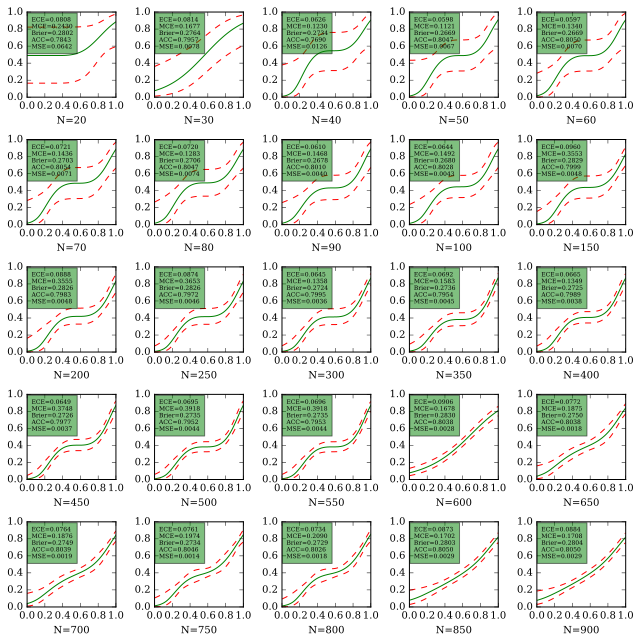

In [11]:
## select data points with highest uncertainty
ece_active_dtm, mce_active_dtm, brier_active_dtm, acc_active_dtm, mse_active_dtm,  subset_active_dtm = active_learning_plot(
    score, Y_predict, Y_true, acq_active_dtm, subset_init, training_list, NUM_SAMPLES, gam_ref)

### Compare different acquisition methods in a single run

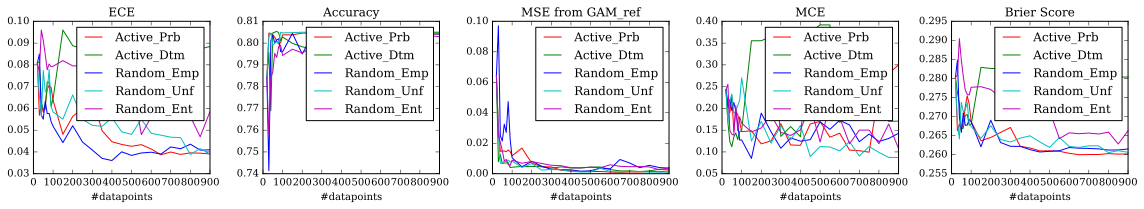

In [12]:
plot_metric_single_run(ece_random_emp, mce_random_emp, brier_random_emp, acc_random_emp, mse_random_emp,\
                       ece_random_unf, mce_random_unf, brier_random_unf, acc_random_unf, mse_random_unf,\
                       ece_random_ent, mce_random_ent, brier_random_ent, acc_random_ent, mse_random_ent,\
                       ece_active_prb, mce_active_prb, brier_active_prb, acc_active_prb, mse_active_prb,\
                       ece_active_dtm, mce_active_dtm, brier_active_dtm, acc_active_dtm, mse_active_dtm, NUM_SAMPLES)

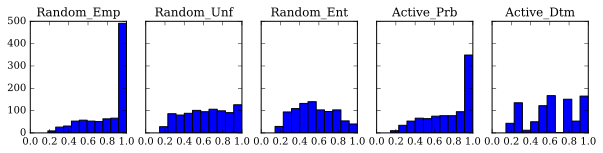

In [13]:
# compare the histogram of scores of datapoints selected with different methods
fig, ax = plt.subplots(nrows=1, ncols=5, sharey = True)
fig.set_figheight(2)
fig.set_figwidth(10)
ax[0].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_emp])
ax[0].set_xlim(0.0, 1.0)
ax[0].set_title("Random_Emp")
ax[1].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_unf])
ax[1].set_xlim(0.0, 1.0)
ax[1].set_title("Random_Unf")
ax[2].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_ent])
ax[2].set_xlim(0.0, 1.0)
ax[2].set_title("Random_Ent")
ax[3].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_prb])
ax[3].set_xlim(0.0, 1.0)
ax[3].set_title("Active_Prb")
ax[4].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_dtm])
ax[4].set_xlim(0.0, 1.0)
ax[4].set_title("Active_Dtm")

## Multiple runs to get errorbars

In [14]:
######### run spline_run.py for a given dataset for multiple runs.
# results will be written to output/DATASET with filenames ece_random.csv, 
# ece_active.csv, acc_random.csv, acc_active.csv.

# disij@datalab-5 22:19:44 ~/projects/sandbox/nn_assessor
# python spline_run.py

ece_random_emp_multi_run = LoadCsvFromOutput("output/%s/ece_random_emp.csv" % DATASET)
mce_random_emp_multi_run = LoadCsvFromOutput("output/%s/mce_random_emp.csv" % DATASET)
brier_random_emp_multi_run = LoadCsvFromOutput("output/%s/brier_random_emp.csv" % DATASET)
acc_random_emp_multi_run = LoadCsvFromOutput("output/%s/acc_random_emp.csv" % DATASET)
mse_random_emp_multi_run = LoadCsvFromOutput("output/%s/mse_random_emp.csv" % DATASET)

ece_random_unf_multi_run = LoadCsvFromOutput("output/%s/ece_random_unf.csv" % DATASET)
mce_random_unf_multi_run = LoadCsvFromOutput("output/%s/mce_random_unf.csv" % DATASET)
brier_random_unf_multi_run = LoadCsvFromOutput("output/%s/brier_random_unf.csv" % DATASET)
acc_random_unf_multi_run = LoadCsvFromOutput("output/%s/acc_random_unf.csv" % DATASET)
mse_random_unf_multi_run = LoadCsvFromOutput("output/%s/mse_random_unf.csv" % DATASET)

ece_random_ent_multi_run = LoadCsvFromOutput("output/%s/ece_random_ent.csv" % DATASET)
mce_random_ent_multi_run = LoadCsvFromOutput("output/%s/mce_random_ent.csv" % DATASET)
brier_random_ent_multi_run = LoadCsvFromOutput("output/%s/brier_random_ent.csv" % DATASET)
acc_random_ent_multi_run = LoadCsvFromOutput("output/%s/acc_random_ent.csv" % DATASET)
mse_random_ent_multi_run = LoadCsvFromOutput("output/%s/mse_random_ent.csv" % DATASET)

ece_active_prb_multi_run = LoadCsvFromOutput("output/%s/ece_active_prb.csv" % DATASET)
mce_active_prb_multi_run = LoadCsvFromOutput("output/%s/mce_active_prb.csv" % DATASET)
brier_active_prb_multi_run = LoadCsvFromOutput("output/%s/brier_active_prb.csv" % DATASET)
acc_active_prb_multi_run = LoadCsvFromOutput("output/%s/acc_active_prb.csv" % DATASET)
mse_active_prb_multi_run = LoadCsvFromOutput("output/%s/mse_active_prb.csv" % DATASET)

ece_active_dtm_multi_run = LoadCsvFromOutput("output/%s/ece_active_dtm.csv" % DATASET)
mce_active_dtm_multi_run = LoadCsvFromOutput("output/%s/mce_active_dtm.csv" % DATASET)
brier_active_dtm_multi_run = LoadCsvFromOutput("output/%s/brier_active_dtm.csv" % DATASET)
acc_active_dtm_multi_run = LoadCsvFromOutput("output/%s/acc_active_dtm.csv" % DATASET)
mse_active_dtm_multi_run = LoadCsvFromOutput("output/%s/mse_active_dtm.csv" % DATASET)

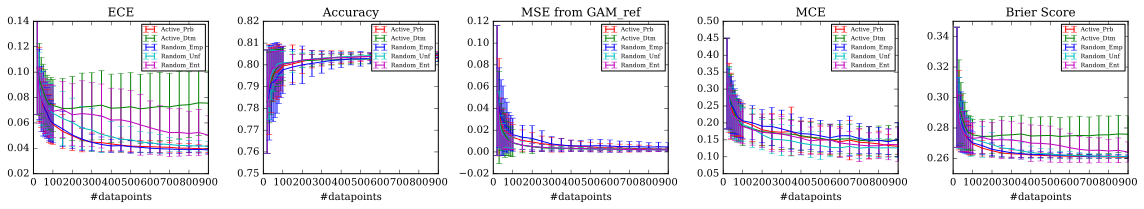

In [15]:
plot_metric_multi_run( ece_random_emp_multi_run, mce_random_emp_multi_run, brier_random_emp_multi_run, \
                              acc_random_emp_multi_run, mse_random_emp_multi_run,\
                       ece_random_unf_multi_run, mce_random_unf_multi_run, brier_random_unf_multi_run, \
                              acc_random_unf_multi_run, mse_random_unf_multi_run,\
                       ece_random_ent_multi_run, mce_random_ent_multi_run, brier_random_ent_multi_run, \
                              acc_random_ent_multi_run, mse_random_ent_multi_run,\
                       ece_active_prb_multi_run, mce_active_prb_multi_run, brier_active_prb_multi_run, \
                              acc_active_prb_multi_run, mse_active_prb_multi_run,\
                       ece_active_dtm_multi_run, mce_active_dtm_multi_run, brier_active_dtm_multi_run, \
                              acc_active_dtm_multi_run, mse_active_dtm_multi_run, NUM_SAMPLES)

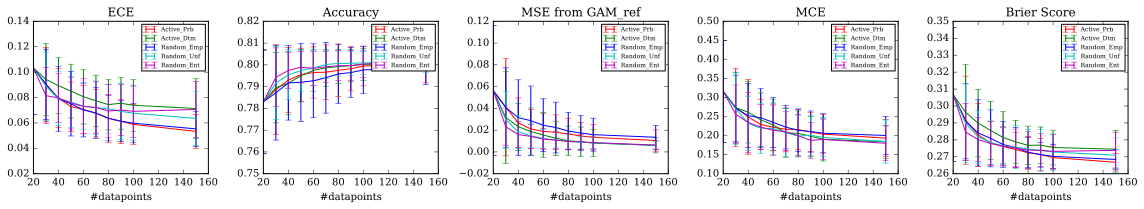

In [16]:
plot_metric_multi_run( ece_random_emp_multi_run, mce_random_emp_multi_run, brier_random_emp_multi_run, \
                              acc_random_emp_multi_run, mse_random_emp_multi_run,\
                       ece_random_unf_multi_run, mce_random_unf_multi_run, brier_random_unf_multi_run, \
                              acc_random_unf_multi_run, mse_random_unf_multi_run,\
                       ece_random_ent_multi_run, mce_random_ent_multi_run, brier_random_ent_multi_run, \
                              acc_random_ent_multi_run, mse_random_ent_multi_run,\
                       ece_active_prb_multi_run, mce_active_prb_multi_run, brier_active_prb_multi_run, \
                              acc_active_prb_multi_run, mse_active_prb_multi_run,\
                       ece_active_dtm_multi_run, mce_active_dtm_multi_run, brier_active_dtm_multi_run, \
                              acc_active_dtm_multi_run, mse_active_dtm_multi_run, NUM_SAMPLES[0:10])